In [7]:
import os
import argparse
from utils import util
from models.cut_seg import CUT_SEG_model
import torch
from utils.create_dataset import EczemaDataset
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle

<h1> plot the loss curve </h1></br>
<h4> plot netG loss </h4>

In [ ]:
loss_path = 'output_HPC/victor_demo_v4/loss/loss_511'

In [ ]:
loss = []
with (open(loss_path, "rb")) as openfile:
    while True:
        try:
            loss.append(pickle.load(openfile))
        except EOFError:
            break
loss = loss[0]

In [ ]:
loss_G = [l['G'] for l in loss]
loss_GAN = [l['G_GAN'] for l in loss]

In [ ]:
plt.plot(loss_G)
plt.xlabel('epoch')
plt.ylabel('netG_loss')

In [ ]:
plt.plot(loss_GAN)
plt.xlabel('epoch')
plt.ylabel('netG_loss')

<h1>Load the network</h1>

In [8]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else: device = torch.device('cpu')

In [9]:
device

device(type='cuda')

In [55]:
def ArgParse():
    parser = argparse.ArgumentParser(description='CUT inference usage.')
    # Evaluation
    # model parameters
    """GAN parameters"""
    parser.add_argument('--CUT_mode', type=str, default="CUT", choices=['CUT', 'cut', 'FastCUT', 'fastcut'], help='')
    parser.add_argument('--input_nc', type=int, default=3, help='# of input image channels: 3 for RGB and 1 for grayscale')
    parser.add_argument('--output_nc', type=int, default=3, help='# of output image channels: 3 for RGB and 1 for grayscale')
    parser.add_argument('--ngf', type=int, default=64, help='# of gen filters in the last conv layer')
    parser.add_argument('--ndf', type=int, default=64, help='# of discrim filters in the first conv layer')
    parser.add_argument('--netD', type=str, default='basic', choices=['basic', 'n_layers'], help='specify discriminator architecture. The basic model is a 70x70 PatchGAN. n_layers allows you to specify the layers in the discriminator')
    parser.add_argument('--netG', type=str, default='resnet_9blocks', choices=['resnet_9blocks', 'resnet_6blocks'], help='specify generator architecture')
    parser.add_argument('--n_layers_D', type=int, default=3, help='only used if netD==n_layers')
    parser.add_argument('--normG', type=str, default='instance', choices=['instance', 'batch', 'none'], help='instance normalization or batch normalization for G')
    parser.add_argument('--normD', type=str, default='instance', choices=['instance', 'batch', 'none'], help='instance normalization or batch normalization for D')
    parser.add_argument('--init_type', type=str, default='xavier', choices=['normal', 'xavier', 'kaiming', 'orthogonal'], help='network initialization')
    parser.add_argument('--init_gain', type=float, default=0.02, help='scaling factor for normal, xavier and orthogonal.')
    parser.add_argument('--no_dropout', type=util.str2bool, nargs='?', const=True, default=True,
                        help='no dropout for the generator')
    parser.add_argument('--antialias', action='store_true', help='if specified, use antialiased-downsampling')
    parser.add_argument('--antialias_up', action='store_true', help='if specified, use [upconv(learned filter)]')
    parser.add_argument('--lambda_GAN', type=float, default=1.0, help='weight for GAN loss：GAN(G(X))')
    """netF paramters"""
    parser.add_argument('--lambda_NCE', type=float, default=1.0, help='weight for NCE loss: NCE(G(X), X)')
    parser.add_argument('--nce_idt', type=util.str2bool, nargs='?', const=True, default=True, help='use NCE loss for identity mapping: NCE(G(Y), Y))')
    parser.add_argument('--nce_layers', type=str, default='0,3,5,7,11', help='compute NCE loss on which layers')
    parser.add_argument('--netF', type=str, default='mlp_sample', choices=['sample', 'reshape', 'mlp_sample'], help='how to downsample the feature map')
    parser.add_argument('--netF_nc', type=int, default=256)
    parser.add_argument('--nce_T', type=float, default=0.07, help='temperature for NCE loss')
    parser.add_argument('--num_patches', type=int, default=256, help='number of patches per layer')
    """netS parameters"""
    parser.add_argument('--netS', type=str, default='resnet', choices=['resnet', 'unet_256', 'smp'], help='how to segment the input image')
    parser.add_argument('--smp_arch', type=str, default='Unet', help='the segmentor architectur')
    parser.add_argument('--smp_encoder', type=str, default='efficientnet-b3', help='the encoder name')
    parser.add_argument('--normS', type=str, default='instance', choices=['instance', 'batch', 'none'], help='instance normalization or batch normalization for S')
    parser.add_argument('--num_class', type=int, default=2, help='# of output image channels for segmented mask')
    parser.add_argument('--netS_lambda', type=int, default=10, help='lambda for SEG loss')
    parser.add_argument('--netS_Loss', type=str, help='semantic segmentation loss function', choices=['dice', 'bce', 'DICE', 'BCE'], default='bce')
    parser.add_argument('--flip_equivariance',
                        type=bool, nargs='?', default=False,
                        help="Enforce flip-equivariance as additional regularization. It's used by FastCUT, but not CUT")
    
    # model parameters for CycleGAN
    parser.add_argument('--CycleGAN', type=util.str2bool, default=False, help='if to use CycleGAN')
    parser.add_argument('--lambda_A', type=float, default=10.0, help='weight for cycle loss (A -> B -> A)')
    parser.add_argument('--lambda_B', type=float, default=10.0, help='weight for cycle loss (B -> A -> B)')
    parser.add_argument('--lambda_identity', type=float, default=0.5, help='use identity mapping. Setting lambda_identity other than 0 has an effect of scaling the weight of the identity mapping loss.\
                        For example, if the weight of the identity loss should be 10 times smaller than the weight of the reconstruction loss, please set lambda_identity = 0.1')
    parser.add_argument('--pool_size', type=int, default=100, help='the size of image pool')

    parser.add_argument('--src_dir', help='source dataset folder', type=str, default='evaluation/clean_source')
    parser.add_argument('--out_dir', help='output folder', type=str, default='evaluation/v9/')
    parser.add_argument('--name', type=str, default='demo_v4', help='name of the experiment. It decides where to store samples and models')
    parser.add_argument('--easy_label', type=str, default='demo_v4', help='Interpretable name')
    parser.add_argument('--checkpoints_dir', type=str, default='./checkpoints', help='models are saved here')

    
    parser.add_argument('--isTrain', type=util.str2bool, default=False)


    opt, _ = parser.parse_known_args()

    # Set default parameters for CUT and FastCUT
    if opt.CUT_mode.lower() == "cut":
        parser.set_defaults(nce_idt=True, lambda_NCE=1.0)
    elif opt.CUT_mode.lower() == "fastcut":
        parser.set_defaults(
            nce_idt=False, lambda_NCE=10.0, flip_equivariance=True,
            n_epochs=150, n_epochs_decay=50
        )
    else:
        raise ValueError(opt.CUT_mode)

    return opt


In [56]:
opt = ArgParse()
opt

Namespace(CUT_mode='CUT', input_nc=3, output_nc=3, ngf=64, ndf=64, netD='basic', netG='resnet_9blocks', n_layers_D=3, normG='instance', normD='instance', init_type='xavier', init_gain=0.02, no_dropout=True, antialias=False, antialias_up=False, lambda_GAN=1.0, lambda_NCE=1.0, nce_idt=True, nce_layers='0,3,5,7,11', netF='mlp_sample', netF_nc=256, nce_T=0.07, num_patches=256, netS='resnet', smp_arch='Unet', smp_encoder='efficientnet-b3', normS='instance', num_class=2, netS_lambda=10, netS_Loss='bce', flip_equivariance=True, CycleGAN=False, lambda_A=10.0, lambda_B=10.0, lambda_identity=0.5, pool_size=100, src_dir='evaluation/clean_source', out_dir='evaluation/v9/', name='demo_v4', easy_label='demo_v4', checkpoints_dir='./checkpoints', isTrain=False)

<h2> load cyclegan </h2>  

In [57]:
from models.cycleGAN import CycleGAN
cyclegan = CycleGAN(opt=opt)

In [58]:
netG_A = getattr(cyclegan, 'netG_A')

In [59]:
if isinstance(netG_A, torch.nn.DataParallel):
    netG_A = netG_A.module

In [60]:
load_path = 'checkpoints_HPC/demo_v9/190_net_G_A.pth'

In [61]:
state_dict = torch.load(load_path, map_location=str(device))

In [62]:
if hasattr(state_dict, '_metadata'):
    del state_dict._metadata

In [63]:
netG_A.load_state_dict(state_dict)

<All keys matched successfully>

<h2> load CUT </h2>

In [47]:
model = CUT_SEG_model(opt=opt)

using device: cuda


In [48]:
netG = getattr(model, 'netG')

In [49]:
if isinstance(netG, torch.nn.DataParallel):
    netG = netG.module

In [50]:
load_path = 'checkpoints_HPC/demo_v8/495_net_G.pth'

In [51]:
state_dict = torch.load(load_path, map_location=str(device))

In [52]:
if hasattr(state_dict, '_metadata'):
    del state_dict._metadata

In [53]:
netG.load_state_dict(state_dict)

<All keys matched successfully>

<h1> create the dataset </h1>

In [19]:
import torch.utils.data as data
import os
from glob import glob
import numpy as np
from torch.autograd import Variable
from PIL import Image
import torch
import torchvision.transforms as T
import torchvision.transforms.functional as TF
import torch.nn.functional as F
from utils.util import img2tensor
import random



class EvaluationDS(data.Dataset):
    
    def __init__(self, src_img_path):
        super().__init__()
        
        self.src_img_path = []
        for ext in ('*.jpg', '*.png', '*.JPG', '*.PNG'):
            self.src_img_path.extend(glob(os.path.join(src_img_path, ext)))

        
    def __len__(self):
        return len(self.src_img_path)
    
    
    def transform(self, real_img):
        # Resize
        resize = T.Resize(size=(286,286), interpolation=T.InterpolationMode.NEAREST)
        real_img = resize(real_img)

        # Random crop
        i, j, h, w = T.RandomCrop.get_params(
            real_img, output_size=(256, 256))
        real_img = TF.crop(real_img, i, j, h, w)
        

        # Random horizontal flipping
        if random.random() > 0.5:
            real_img = TF.hflip(real_img)
            

        return real_img
    
    def normalize(self, real_img):

        normalize = T.Normalize(mean=(127.5,127.5,127.5), std=(127.5,127.5,127.5))
        normalize_real_img = normalize(real_img)
        normalize_real_img = normalize_real_img.squeeze(0)
        
        return normalize_real_img
        
    
    def __getitem__(self, index):
        src_img = np.asarray(Image.open(self.src_img_path[index]))
        src_img = img2tensor(src_img)
        
        t_src_img = self.transform(src_img)

        # normalize the imgs
        n_src_img = self.normalize(t_src_img)
        
        return n_src_img

In [20]:
opt.src_dir

'evaluation/clean_source'

In [21]:
source = EvaluationDS(opt.src_dir)

In [22]:
src_dataloader = DataLoader(source, batch_size=1, shuffle=False)

<h1> generate the translated image and save </h1>

In [23]:
def generate_image(dataloader, netG, opt, device, mode='translated'):
    save_path = os.path.join(opt.out_dir, mode)

    for idx, data in enumerate(dataloader):
        data = data.to(device)
        # translated
        translated = netG(data)
        translated = util.tensor2img(translated)
        translated = (translated * 127.5 + 127.5).astype(np.uint8)

        if mode == 'translated':
            plt.figure(figsize=(20, 20))
            plt.imshow(translated)
            plt.axis('off')
            plt.savefig(f'{save_path}/infer={idx + 1}.png')
            plt.close()
        
        elif mode == 'compare':
            # source
            source_img = util.tensor2img(data)
            source_img = (source_img * 127.5 + 127.5).astype(np.uint8)

            _, ax = plt.subplots(1, 2, figsize=(20, 20))
            ax[0].imshow(source_img)
            ax[1].imshow(translated)
            ax[0].set_title("Input")
            ax[1].set_title("Translated")
            ax[0].axis("off")
            ax[1].axis("off")

            plt.savefig(f'{save_path}/infer={idx + 1}.png')
            plt.close()            

In [ ]:
# generate compare images
generate_image(src_dataloader, netG=netG, opt=opt, device=device, mode='compare')

In [64]:
# generate translated images
generate_image(src_dataloader, netG=netG_A, opt=opt, device=device, mode='translated')

: 

In [10]:
from PIL import Image
import os, sys
import glob, re
from os import listdir
from os.path import isfile, join

path = "datasets/victor_dataset/non_white/train"

dirs = [f for f in listdir(path) if isfile(join(path, f))]
# dirs = []
# for ext in ('*.jpg', '*.png', '*.JPG', '*.PNG'):
#     dirs.extend(glob(os.path.join(dirs, ext)))

def resize():
    for item in dirs:
        name = re.split('[/]', item)[-1]
        im = Image.open(os.path.join(path,item))
        imResize = im.resize((256,256), Image.ANTIALIAS)
        imResize.save(os.path.join('datasets/victor_dataset/resized_nonwhite', name))

resize()

/var/folders/xd/vgr9x5c91pqf90hx6b_x1mxm0000gn/T/ipykernel_12485/2811635073.py:18: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  imResize = im.resize((256,256), Image.ANTIALIAS)


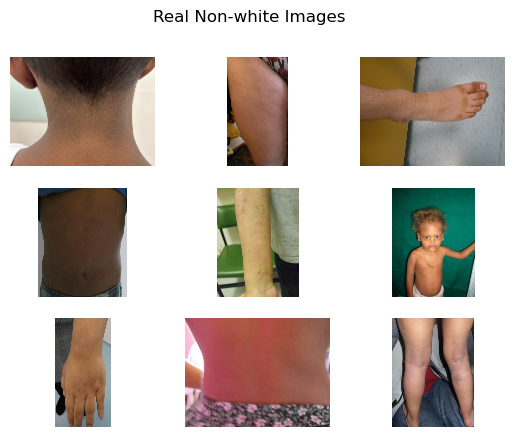

In [16]:
import random
import matplotlib.pyplot as plt


random_real_list = random.sample(dirs, 9)

figure, axes = plt.subplots(3, 3)   # (columns, rows)
for i, ax in enumerate(axes.ravel()):
    img = plt.imread(os.path.join(path,random_real_list[i]))
    ax.imshow(img)
    ax.axis('off')

plt.suptitle('Real Non-white Images')
plt.savefig('experiment_2/random_real.pdf')

In [25]:
real_path = "datasets/victor_dataset/resized_nonwhite"
real_img = [os.path.join(real_path, f) for f in listdir(real_path) if isfile(join(real_path, f))]

fake_path = "datasets/victor_dataset/translated_img/victor_dataset/ag/ag_vic_lr1e-6_pix2/translated"
fake_img = [os.path.join(fake_path, f) for f in listdir(fake_path) if isfile(join(fake_path, f))]

In [30]:
seed = random.seed(123)

non_whtie_real = random.sample(real_img, 72)
non_white_fake = random.sample(fake_img, 108)

In [31]:
real_fake = non_whtie_real + non_white_fake

random.shuffle(real_fake)

In [36]:
print(real_fake)

['datasets/victor_dataset/translated_img/victor_dataset/ag/ag_vic_lr1e-6_pix2/translated/infer=9.png', 'datasets/victor_dataset/resized_nonwhite/27f55f3e-86b7-4a59-84a3-1ba368311a7f.png', 'datasets/victor_dataset/resized_nonwhite/3119_wk16.JPG', 'datasets/victor_dataset/resized_nonwhite/2124_wk00_2.JPG', 'datasets/victor_dataset/resized_nonwhite/7e1c41cb-5b6b-4f3a-a8a8-58fb0d62834c.JPG', 'datasets/victor_dataset/translated_img/victor_dataset/ag/ag_vic_lr1e-6_pix2/translated/infer=42.png', 'datasets/victor_dataset/resized_nonwhite/3fb34cd3-efac-4cdd-a104-cdca4219a784.jpg', 'datasets/victor_dataset/resized_nonwhite/fa855004-59b9-4431-a3f6-eab59aec2221.jpg', 'datasets/victor_dataset/translated_img/victor_dataset/ag/ag_vic_lr1e-6_pix2/translated/infer=172.png', 'datasets/victor_dataset/resized_nonwhite/dbb37683-0229-49bb-8fdf-9bdec002feb1.JPG', 'datasets/victor_dataset/resized_nonwhite/5c9f5905-5b82-487c-a9d3-0ceec28fccdc.jpg', 'datasets/victor_dataset/translated_img/victor_dataset/ag/ag_v

In [41]:
import pickle

with open('experiment_2/TRUTH.pkl', 'wb') as f:
    pickle.dump(real_fake, f)

In [39]:
for i in range(0, len(real_fake), 9):
    files = real_fake[i:i+9]
    figure, axes = plt.subplots(3, 3)   # (columns, rows)
    for j, ax in enumerate(axes.ravel()):
        img = plt.imread(files[j])
        ax.imshow(img)
        ax.axis('off')
    
    plt.suptitle('Real or Fake')
    plt.savefig(f'experiment_2/question_{i // 9}.pdf')
    print('done')
    plt.close()

done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done


In [47]:
import shutil


save_path = 'experiment_2'
for i in range(len(real_fake)):
    folder_name = os.path.join(save_path, f'question_{i%20}')
    if not os.path.isdir(folder_name):
        os.mkdir(folder_name)
    dst_path = os.path.join(folder_name, real_fake[i].split('/')[-1])
    shutil.copyfile(real_fake[i], dst=dst_path)

In [52]:
non_white_fake

['datasets/victor_dataset/translated_img/victor_dataset/ag/ag_vic_lr1e-6_pix2/translated/infer=115.png',
 'datasets/victor_dataset/translated_img/victor_dataset/ag/ag_vic_lr1e-6_pix2/translated/infer=112.png',
 'datasets/victor_dataset/translated_img/victor_dataset/ag/ag_vic_lr1e-6_pix2/translated/infer=4.png',
 'datasets/victor_dataset/translated_img/victor_dataset/ag/ag_vic_lr1e-6_pix2/translated/infer=35.png',
 'datasets/victor_dataset/translated_img/victor_dataset/ag/ag_vic_lr1e-6_pix2/translated/infer=46.png',
 'datasets/victor_dataset/translated_img/victor_dataset/ag/ag_vic_lr1e-6_pix2/translated/infer=200.png',
 'datasets/victor_dataset/translated_img/victor_dataset/ag/ag_vic_lr1e-6_pix2/translated/infer=43.png',
 'datasets/victor_dataset/translated_img/victor_dataset/ag/ag_vic_lr1e-6_pix2/translated/infer=95.png',
 'datasets/victor_dataset/translated_img/victor_dataset/ag/ag_vic_lr1e-6_pix2/translated/infer=41.png',
 'datasets/victor_dataset/translated_img/victor_dataset/ag/ag_

In [59]:
path = 'datasets/victor_dataset/translated_img/victor_dataset/ag/ag_vic_lr1e-6_pix2/translated'
for f_name in os.listdir(path):
    src_path = os.path.join(path, f_name)
    if not  src_path in non_white_fake:
        shutil.copyfile(src_path, os.path.join('experiment_2/left_img',f_name))

In [56]:
'datasets/victor_dataset/translated_img/victor_dataset/ag/ag_vic_lr1e-6_pix2/translated/infer=10.png' in non_white_fake

True

In [ ]:
random_real_list

save_path = 'experiment_2'
for i in range(len(random_real_list)):
    folder_name = os.path.join(save_path, f'real')
    if not os.path.isdir(folder_name):
        os.mkdir(folder_name)
    dst_path = os.path.join(folder_name, random_real_list[i].split('/')[-1])
    shutil.copyfile(real_fake[i], dst=dst_path)